<a href="https://colab.research.google.com/github/edsonportosilva/OptiCommPy/blob/main/examples/benchmarck_GPU_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Benchmarck GPU processing

In this notebook, a benchmark analysis is conducted to assess the processing time necessary for simulating signal propagation through the nonlinear fiber model, specifically employing the Manakov model. The propagation simulation is implemented numerically, utilizing a split-step Fourier (SSF) algorithm.

In [1]:
if 'google.colab' in str(get_ipython()):
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install .

fatal: destination path 'OptiCommPy' already exists and is not an empty directory.
Processing /content/OptiCommPy
  Preparing metadata (setup.py) ... done
  Created wheel for OptiCommPy: filename=OptiCommPy-0.9.0-py3-none-any.whl size=77755 sha256=85b8b67722fd95cbe86324082499bc6d322e86fc38f34725dde4306fa1569eaf
  Stored in directory: /tmp/pip-ephem-wheel-cache-ezkiyd_z/wheels/9e/f3/8b/afabbf8928f62ae99a9b1ff6cd1517ecf94ac8ce265d6f0ae0
Successfully built OptiCommPy
  Attempting uninstall: OptiCommPy
    Found existing installation: OptiCommPy 0.9.0
    Uninstalling OptiCommPy-0.9.0:
      Successfully uninstalled OptiCommPy-0.9.0


In [9]:
import matplotlib.pyplot as plt
import numpy as np

from optic.models.modelsGPU import manakovSSF as manakovSSF_GPU
from optic.models.channels import manakovSSF as manakovSSF_CPU, awgn
from optic.dsp.coreGPU import firFilter as firFilter_GPU
from optic.dsp.core import firFilter as firFilter_CPU
from optic.dsp.carrierRecovery import cpr
from optic.models.devices import pdmCoherentReceiver, basicLaserModel
from optic.dsp.core import pulseShape, decimate, pnorm, firFilter
from optic.models.tx import simpleWDMTx
from optic.utils import parameters

import logging as logg
logg.basicConfig(level=logg.WARN, format='%(message)s', force=True)

import time
from tqdm.notebook import tqdm

In [4]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [5]:
figsize(10, 3)

In [6]:
%load_ext autoreload
%autoreload 2
#%load_ext line_profiler

## Signal parameters

In [7]:
# Transmitter parameters:
paramTx = parameters()
paramTx.M   = 16           # order of the modulation format
paramTx.Rs  = 32e9         # symbol rate [baud]
paramTx.SpS = 4            # samples per symbol
paramTx.pulse = 'rrc'      # pulse shaping filter
paramTx.Ntaps = 4096       # number of pulse shaping filter coefficients
paramTx.alphaRRC = 0.01    # RRC rolloff
paramTx.Pch_dBm = -2       # power per WDM channel [dBm]
paramTx.Nch     = 1        # number of WDM channels
paramTx.Fc      = 193.1e12 # central optical frequency of the WDM spectrum
paramTx.lw      = 100e3    # laser linewidth in Hz
paramTx.freqSpac = 37.5e9  # WDM grid spacing
paramTx.Nmodes = 2         # number of signal modes [2 for polarization multiplexed signals]
paramTx.prgsBar = False    # show progress bar

# optical channel parameters
paramCh = parameters()
paramCh.Ltotal = 500     # total link distance [km]
paramCh.Lspan  = 50      # span length [km]
paramCh.alpha = 0.2      # fiber loss parameter [dB/km]
paramCh.D = 16           # fiber dispersion parameter [ps/nm/km]
paramCh.gamma = 1.3      # fiber nonlinear parameter [1/(W.km)]
paramCh.Fc = paramTx.Fc  # central optical frequency of the WDM spectrum
paramCh.hz = 0.5         # step-size of the split-step Fourier method [km]
paramCh.maxIter = 5      # maximum number of convergence iterations per step
paramCh.tol = 1e-5       # error tolerance per step
paramCh.nlprMethod = True # use adaptive step-size based o maximum nonlinear phase-shift
paramCh.maxNlinPhaseRot = 2e-2 # maximum nonlinear phase-shift per step
paramCh.prgsBar = False   # show progress bar
#paramCh.saveSpanN = [1, 5, 9, 14]
paramCh.Fs = paramTx.Rs*paramTx.SpS # sampling rate

## Compare CPU vs GPU processing

### manakovSSF

In [ ]:
numberOfSymbols = np.array([5e3, 1e4, 2e4, 5e4, 1e5, 2e5, 5e5])

timeCPU = np.zeros(len(numberOfSymbols))
timeGPU = np.zeros(len(numberOfSymbols))

paramTx.Pch_dBm = -2 # power per WDM channel [dBm]

for idx, Nsymb in enumerate(tqdm(numberOfSymbols)):
    paramTx.Nbits = int(np.log2(paramTx.M)*Nsymb) # total number of bits per polarization
    # generate WDM signal
    sigWDM_Tx, symbTx_, paramTx = simpleWDMTx(paramTx)

    # nonlinear signal propagation
    start = time.time()
    sigWDM = manakovSSF_CPU(sigWDM_Tx, paramCh)
    end = time.time()
    timeCPU[idx] = end - start

    # nonlinear signal propagation
    start = time.time()
    sigWDM = manakovSSF_GPU(sigWDM_Tx, paramCh)
    end = time.time()
    timeGPU[idx] = end - start

  0%|          | 0/7 [00:00<?, ?it/s]

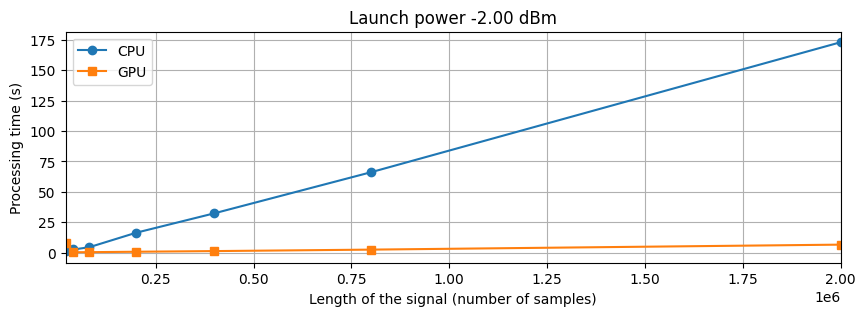

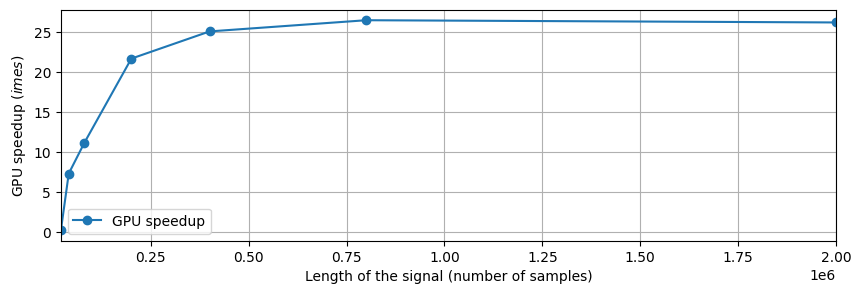

In [ ]:
signalLength = numberOfSymbols*paramTx.SpS

plt.plot(signalLength, timeCPU,'-o', label='CPU')
plt.plot(signalLength, timeGPU,'-s', label='GPU')
plt.xlabel('Length of the signal (number of samples)')
plt.ylabel('Processing time (s)')
plt.title(f'Launch power {paramTx.Pch_dBm:.2f} dBm')
plt.legend()
plt.grid()
plt.xlim(min(signalLength), max(signalLength))

plt.figure()
plt.plot(signalLength, timeCPU/timeGPU,'-o', label='GPU speedup')
plt.xlabel('Length of the signal (number of samples)')
plt.ylabel('GPU speedup ($\times$)')
plt.legend()
plt.grid()
plt.xlim(min(signalLength), max(signalLength));

In [ ]:
timeCPU = np.zeros(len(numberOfSymbols))
timeGPU = np.zeros(len(numberOfSymbols))

paramTx.Pch_dBm = 4 # power per WDM channel [dBm]

for idx, Nsymb in enumerate(tqdm(numberOfSymbols)):
    paramTx.Nbits = int(np.log2(paramTx.M)*Nsymb) # total number of bits per polarization
    # generate WDM signal
    sigWDM_Tx, symbTx_, paramTx = simpleWDMTx(paramTx)

    # nonlinear signal propagation
    start = time.time()
    sigWDM = manakovSSF_CPU(sigWDM_Tx, paramCh)
    end = time.time()
    timeCPU[idx] = end - start

    # nonlinear signal propagation
    start = time.time()
    sigWDM = manakovSSF_GPU(sigWDM_Tx, paramCh)
    end = time.time()
    timeGPU[idx] = end - start

  0%|          | 0/7 [00:00<?, ?it/s]

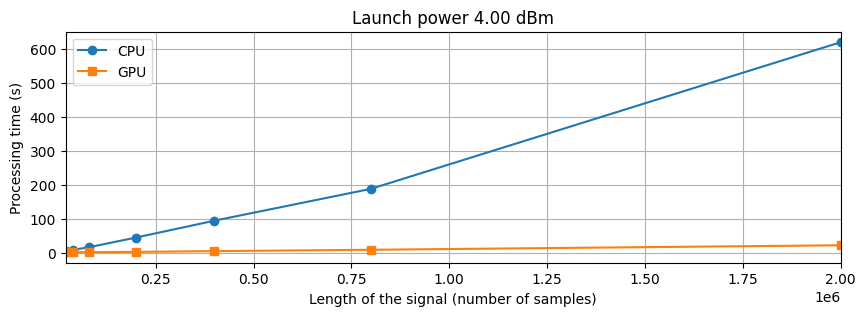

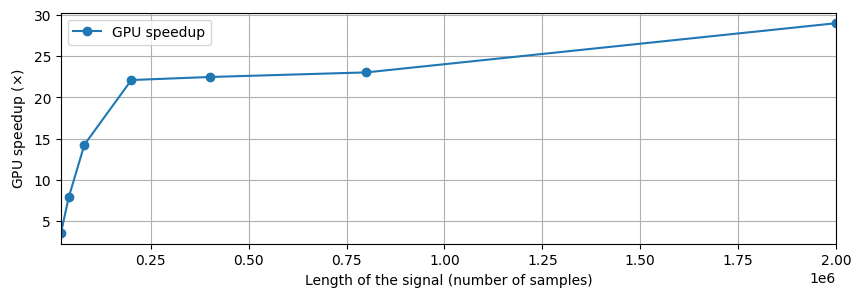

In [ ]:
signalLength = numberOfSymbols*paramTx.SpS

plt.plot(signalLength, timeCPU,'-o', label='CPU')
plt.plot(signalLength, timeGPU,'-s', label='GPU')
plt.xlabel('Length of the signal (number of samples)')
plt.ylabel('Processing time (s)')
plt.title(f'Launch power {paramTx.Pch_dBm:.2f} dBm')
plt.legend()
plt.grid()
plt.xlim(min(signalLength), max(signalLength))


plt.figure()
plt.plot(signalLength, timeCPU/timeGPU,'-o', label='GPU speedup')
plt.xlabel('Length of the signal (number of samples)')
plt.ylabel('GPU speedup ($\\times$)')
plt.legend()
plt.grid()
plt.xlim(min(signalLength), max(signalLength));

### Compilation of results (length of the signal $>10^6$ samples)


| System configuration                     | GPU improvement  |
|:-----------------------------------|:------------------|
|Windows 64 bits Intel(R) Core(TM) i7-9700 CPU 3.00 GHz RAM 16.0 GB NVIDIA GeForce GTX 1060 6GB CUDA Version: 12.4| $\approx$ 17.5 - 20x|
|Google Colab System RAM 12.7 GB NVIDIA Tesla T4 15GB CUDA Version: 12.2| $\approx$  25x|

### firFilter

In [ ]:
h = pulseShape('rrc')
numberOfSymbols = np.array([5e3, 1e4, 2e4, 5e4, 1e5, 2e5, 5e5])

timeCPU = np.zeros(len(numberOfSymbols))
timeGPU = np.zeros(len(numberOfSymbols))

nTrials = 20

for _ in tqdm(range(nTrials)):
    for idx, Nsymb in enumerate(numberOfSymbols):
        paramTx.Nbits = int(np.log2(paramTx.M)*Nsymb) # total number of bits per polarization
        # generate WDM signal
        sigWDM_Tx, symbTx_, paramTx = simpleWDMTx(paramTx)

        # fir filtering
        start = time.time()
        sigFilt = firFilter_CPU(h, sigWDM_Tx)
        end = time.time()
        timeCPU[idx] += end - start

        # fir filtering
        start = time.time()
        sigFilt = firFilter_GPU(h, sigWDM_Tx)
        end = time.time()
        timeGPU[idx] += end - start

timeGPU /= nTrials
timeCPU /= nTrials

  0%|          | 0/20 [00:00<?, ?it/s]

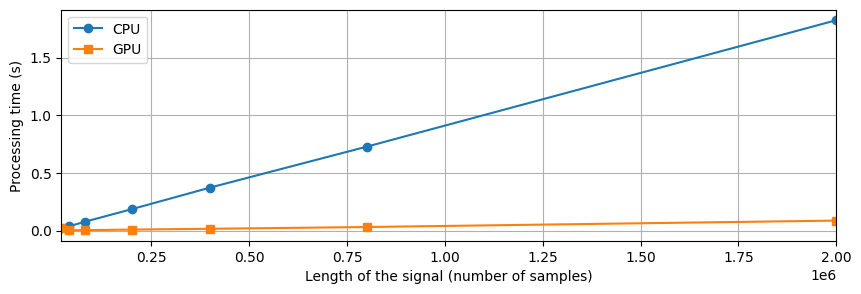

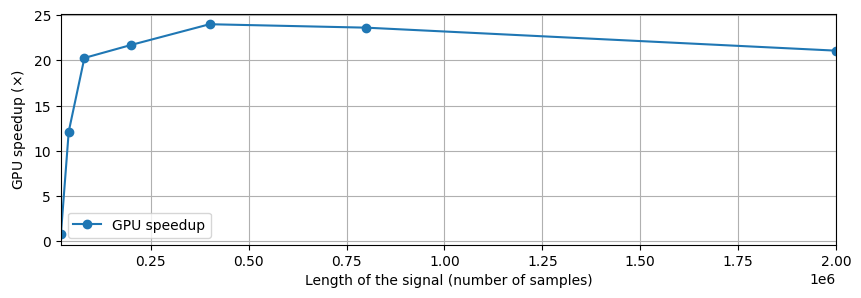

In [ ]:
signalLength = numberOfSymbols*paramTx.SpS

plt.plot(signalLength, timeCPU,'-o', label='CPU')
plt.plot(signalLength, timeGPU,'-s', label='GPU')
plt.xlabel('Length of the signal (number of samples)')
plt.ylabel('Processing time (s)')
plt.legend()
plt.grid()
plt.xlim(min(signalLength), max(signalLength))


plt.figure()
plt.plot(signalLength, timeCPU/timeGPU,'-o', label='GPU speedup')
plt.xlabel('Length of the signal (number of samples)')
plt.ylabel('GPU speedup ($\\times$)')
plt.legend()
plt.grid()
plt.xlim(min(signalLength), max(signalLength));

### Compilation of results (length of the signal $>10^6$ samples)


| System configuration                     | GPU improvement  |
|:-----------------------------------|:------------------|
|Windows 64 bits Intel(R) Core(TM) i7-9700 CPU 3.00 GHz RAM 16.0 GB NVIDIA GeForce GTX 1060 6GB CUDA Version: 12.4| $\approx$ 16x|
|Google Colab System RAM 12.7 GB NVIDIA Tesla T4 15GB CUDA Version: 12.2| $\approx$ 20x|

### Carrier phase recovery BPS algorithm

In [10]:
numberOfSymbols = np.array([5e3, 1e4, 2e4, 5e4, 1e5, 2e5])

timeCPU = np.zeros(len(numberOfSymbols))
timeGPU = np.zeros(len(numberOfSymbols))

nTrials = 20

for _ in tqdm(range(nTrials)):
    for idx, Nsymb in enumerate(numberOfSymbols):
        paramTx.Nbits = int(np.log2(paramTx.M)*Nsymb) # total number of bits per polarization
        # generate WDM signal
        sigWDM_Tx, symbTx_, paramTx = simpleWDMTx(paramTx)

        SNRdB = 15
        sigCh = awgn(sigWDM_Tx, SNRdB, paramCh.Fs, paramTx.Rs)

        # parameters
        chIndex  = 0    # index of the channel to be demodulated

        freqGrid = paramTx.freqGrid
        π  = np.pi
        t  = np.arange(0, len(sigCh))*1/paramCh.Fs

        symbTx = symbTx_[:,:,chIndex]

        # local oscillator (LO) parameters:
        FO      = 60e6                  # frequency offset
        Δf_lo   = freqGrid[chIndex]+FO  # downshift of the channel to be demodulated

        # generate CW laser LO field
        paramLO = parameters()
        paramLO.P = 10              # power in dBm
        paramLO.lw = 100e3          # laser linewidth
        paramLO.RIN_var = 0
        paramLO.Ns = len(sigCh)
        paramLO.Fs = paramCh.Fs

        sigLO = basicLaserModel(paramLO)
        sigLO = sigLO*np.exp(1j*2*π*Δf_lo*t) # add frequency offset

        # polarization multiplexed coherent optical receiver
        sigRx = pdmCoherentReceiver(sigCh, sigLO, θsig = 0)

        # Rx filtering

        # Matched filtering
        if paramTx.pulse == 'nrz':
            pulse = pulseShape('nrz', paramTx.SpS)
        elif paramTx.pulse == 'rrc':
            pulse = pulseShape('rrc', paramTx.SpS, N=paramTx.Ntaps, alpha=paramTx.alphaRRC, Ts=1/paramTx.Rs)

        pulse = pnorm(pulse)
        sigRx = firFilter(pulse, sigRx)

        # decimation
        paramDec = parameters()
        paramDec.SpS_in  = paramTx.SpS
        paramDec.SpS_out = 1
        sigRx = decimate(sigRx, paramDec)

        # run BPS CPU
        paramCPR = parameters()
        paramCPR.alg = 'bps'
        paramCPR.M   = paramTx.M
        paramCPR.constType = paramTx.constType
        paramCPR.N   = 85
        paramCPR.B   = 64
        paramCPR.returnPhases = True

        start = time.time()
        y_CPR, phi = cpr(sigRx, paramCPR)
        end = time.time()
        timeCPU[idx] = end - start

        # run BPS GPU
        paramCPR = parameters()
        paramCPR.alg = 'bpsGPU'
        paramCPR.M   = paramTx.M
        paramCPR.constType = paramTx.constType
        paramCPR.N   = 85
        paramCPR.B   = 64
        paramCPR.returnPhases = True

        start = time.time()
        y_CPR, phi = cpr(sigRx, paramCPR)
        end = time.time()
        timeGPU[idx] = end - start

  0%|          | 0/20 [00:00<?, ?it/s]

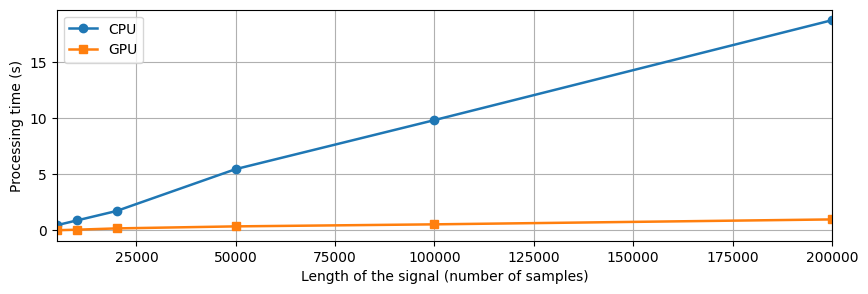

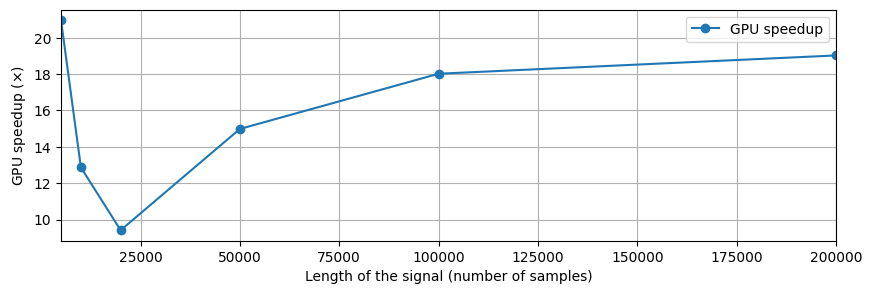

In [16]:
plt.plot(numberOfSymbols, timeCPU, '-o', linewidth=1.8, label='CPU')
plt.plot(numberOfSymbols, timeGPU, '-s', linewidth=1.8, label='GPU')
plt.xlabel('Length of the signal (number of samples)')
plt.ylabel('Processing time (s)')
plt.legend()
plt.grid()
plt.xlim(min(numberOfSymbols), max(numberOfSymbols));

plt.figure()
plt.plot(numberOfSymbols, timeCPU/timeGPU,'-o', label='GPU speedup')
plt.xlabel('Length of the signal (number of samples)')
plt.ylabel('GPU speedup ($\\times$)')
plt.legend()
plt.grid()
plt.xlim(min(numberOfSymbols), max(numberOfSymbols));

### Compilation of results (length of the signal $>10^5$ samples)

| System configuration                     | GPU improvement  |
|:-----------------------------------|:------------------|
|Google Colab System RAM 12.7 GB NVIDIA Tesla T4 15GB CUDA Version: 12.2| $\approx$ 19x|